In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('ggplot')



In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv')
df = pd.read_csv('takehome_users.csv', encoding = 'latin') #Getting the data loaded


In [3]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


The main useful information here is that relatively few members opted for the mailing list (about 25%) or are enabled for maketing drip (15%).

In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


There are missing values for the last_session_creation_time and who they were invited by. There are no missing values in the engagement dataframe. It is also of note that the last_session_creation_time appears to be in the wrong format. 

### The plan
I will use the engagement data to identify users who log on at least 3 times in a seven day period. Then using those user_id's, I will use the main dataframe to identify features that predict if the user will be active. Initial thoughts are that creation_source, org_id, mailing_list, market_drip, and perhaps if they were invited (not by whom, just if they were) could be good predictors.

In [8]:
# selecting only the users who appear at least 3 times anyway since they can't occur three times in a week with less than 3 occurances
engage = engagement.groupby('user_id').filter(lambda x: len(x) >= 3)


In [9]:
engage.reset_index(drop=True, inplace = True) # by removing the rows the index is now off, so reset

In [10]:
#this sequence runs through the dataframe, creates a week from a date, and then checks if the next two dates fall within that
#time. Then it ouputs the user_id to a list.
active = 0
active_users = []
for i in range(len(engage)-2):
    user = engage['user_id'][i] #get current user_id
    if user != active and user == engage['user_id'][i+2]: #so we can skip a user that has already been active and to make sure we don't compare to the next user
        st = pd.Timestamp(engage['time_stamp'][i]) #get start date
        et = st + pd.Timedelta('7D') # make range for end date
        if st < pd.Timestamp(engage['time_stamp'][i+1]) < et and st < pd.Timestamp(engage['time_stamp'][i+2]) < et:
            active_users.append(user) # now that the active condition has been met, return that user
            active = user                  #define the user as active


In [11]:
len(active_users)

1602

In [12]:
y = pd.Series(np.random.randn(len(df)))
n = 0
for i in range(len(df)):
    if df['object_id'][i] == active_users[n]:
        y[i] = 1
        n = n+1
        if n > len(active_users)-1:
            n = n -1
    else:
        y[i] = 0
y.head()

0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
dtype: float64

In [13]:
df1 = pd.DataFrame(y,columns = ['active_users'])

In [14]:
df = pd.concat([df,df1], axis = 1)

In [15]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_users
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [16]:
# This is to turn the invited column into simply a binary 'was invited' or 'not'
inv = pd.Series(np.random.randn(len(df)))
for i in range(len(df)):
    if df['invited_by_user_id'][i] >=1:
        inv[i] = 1
    else:
        inv[i] = 0
df2 = pd.DataFrame(inv, columns = ['invited'])
df = pd.concat([df,df2], axis = 1)

In [17]:
inv.value_counts()

1.0    6417
0.0    5583
dtype: int64

Alright, we have identified the active users and identified them in the dataframe as the column active_users so that we can now use that to discover which features predict active users.

One thing to note here is that the early creation times did not produce active users as frequently.

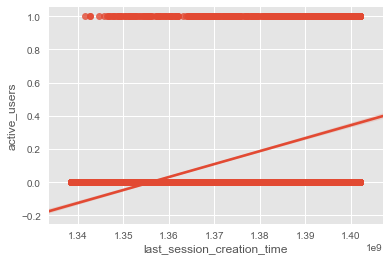

In [18]:
sns.regplot(y=df['active_users'], x=df['last_session_creation_time'], fit_reg = True)

Last step is to turn the creation_source information into numbers so that sklearn/xgboost are happy.

In [22]:
df['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['ORG_INVITE','GUEST_INVITE','PERSONAL_PROJECTS','SIGNUP','SIGNUP_GOOGLE_AUTH'])

LabelEncoder()

In [24]:
creation = le.transform(df['creation_source'])

In [26]:
df3 = pd.DataFrame(creation,columns = ['creation'])

In [28]:
df = pd.concat([df,df3],axis=1)

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

C:\Users\asduser\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
y = df['active_users']
X = df[['creation','last_session_creation_time','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id']]

In [36]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

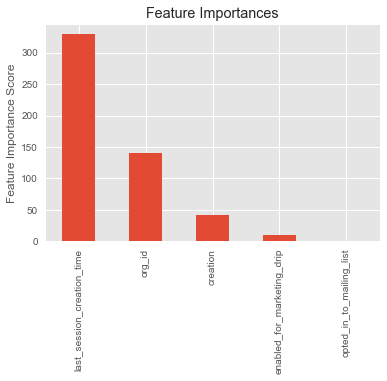

In [37]:
feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [38]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.97%


## Conclusion
With little optimization this model can predict an active user with 92% accuracy. With that in mind, it appears that the most important features for making this prediction are the "last session creation time", the organization the user is from, the "creation source", and if they are in a marketing drip.